In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
import matplotlib.cm as cm
import seaborn as sns
from matplotlib import gridspec
import matplotlib.animation as manimation
import time
import scipy.io as sio
from random import shuffle
import time
from collections import Counter
import sklearn.cluster as cluster
import time
import hdbscan
from os import listdir
import sys
from os.path import isfile, join
import os
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
from pathlib import Path

# own modules in dir
sys.path.insert(0, '/home/bojk/custom_pymodules')
os.chdir('..')




In [2]:
%pwd

'/home/bojk/Data'

In [3]:
moddf = pd.read_pickle('KEGG_module_list')
KEGGmoddf = pd.read_pickle('KEGG_modules_df')
COGcat = pd.read_table('COGreffiles/fun2003-2014.tab')
COGtab = pd.read_table('COGreffiles/cognames2003-2014.tab')
COGtab['NameNum'] = COGtab['name']+' - '+COGtab['COG']
COGtab['FuncCat'] = [COGcat[COGcat['# Code']==i[0]]['Name'].values[0] for i in COGtab['func']]
COGtab.FuncCat.value_counts()

Function unknown                                                 959
General function prediction only                                 507
Translation, ribosomal structure and biogenesis                  326
Energy production and conversion                                 268
Amino acid transport and metabolism                              265
Carbohydrate transport and metabolism                            239
Inorganic ion transport and metabolism                           210
Coenzyme transport and metabolism                                204
Cell wall/membrane/envelope biogenesis                           204
Transcription                                                    186
Replication, recombination and repair                            176
Posttranslational modification, protein turnover, chaperones     172
Signal transduction mechanisms                                   144
Nucleotide transport and metabolism                              115
Mobilome: prophages, transposons  

# this analyzes the OP aquificae

In [4]:
OPaquificae = [2770939329,2770939370,2770939407]
mypath = 'Obsidian_Pool/aquificae/'
IMGID = [f for f in listdir(mypath) if '.' not in f and 'Knumbers' not in f and 'Analysis' not in f]
ktab = pd.DataFrame(index=range(10000),columns=IMGID)
ptab = pd.DataFrame(index=range(10000),columns=IMGID)
ctab = pd.DataFrame(index=range(10000),columns=IMGID)
ctab_thr = pd.DataFrame(index=range(10000),columns=IMGID)


for bins in IMGID:
    cpath = mypath+bins+'/'+bins+'.cog.tab.txt'
    kpath = mypath+bins+'/'+bins+'.ko.tab.txt'
    ppath = mypath+bins+'/'+bins+'.pfam.tab.txt'
    
    ktab[bins] =  pd.read_csv(kpath,'\t')['ko_id'].str[3:]
    if os.path.isdir(mypath+'Knumbers')==True:
        ktab[bins].to_csv(mypath+'Knumbers/'+bins+'.txt',sep='\t') #write to file for mapper
    else:
        os.mkdir(mypath+'Knumbers')
        ktab[bins].to_csv(mypath+'Knumbers/'+bins+'.txt',sep='\t') #write to file for mapper
           
    pfamtemp =  pd.read_csv(ppath,'\t')[['pfam_id','pfam_name']]
    pfamtemp['namenum'] = pfamtemp['pfam_id']+', '+pfamtemp['pfam_name']
    ptab[bins] = pfamtemp['namenum']
    
    ctab[bins] = pd.read_csv(cpath,'\t')['cog_id']
    ctab_thr[bins] = pd.read_csv(cpath,'\t')['percent_identity']

In [5]:
name = 'Obsidian_Pool/aquificae/Analysis/COG_percent_ID_clade.table'
if isfile(name)==True:
    cmap_thr = pd.read_table(name)
else:
    cmap_thr = pd.DataFrame(index=COGtab.set_index('COG').index,columns=ctab.columns)
    for cols in ctab.columns:
        for cogs in ctab[cols].dropna().unique():
            ind = ctab[cols].dropna()[ctab[cols].dropna().str.contains(cogs)].index.values
            if len(ind)>0:
                val = max(ctab_thr.loc[list(ind),cols])
                cmap_thr.loc[cogs,cols] = val
    cmap_thr.index =  COGtab.set_index('COG').loc[cmap_thr.index]['NameNum']
    cmap_thr.to_csv(name,sep='\t')

In [6]:
def COGmapper(df):
    # gets ctab formatted df into mappable one
    mapdf = pd.DataFrame(index=COGtab.set_index('COG').index,columns=df.columns)
    for names in df.columns:
        mapdf.loc[df[names].dropna(how='any').values,names] = 1
    return(mapdf)

In [7]:
# COG dfs with different percent identity threshold values 
ctab_30 = ctab[ctab_thr>30]
ctab_40 = ctab[ctab_thr>40]
ctab_50 = ctab[ctab_thr>50]
ctab_60 = ctab[ctab_thr>60]
ctab_70 = ctab[ctab_thr>70]
ctab_80 = ctab[ctab_thr>80]

# make heatmap-like dfs 
cmap = COGmapper(ctab)
cmap_30 = COGmapper(ctab_30)
cmap_40 = COGmapper(ctab_40)
cmap_50 = COGmapper(ctab_50)
cmap_60 = COGmapper(ctab_60)
cmap_70 = COGmapper(ctab_70)
cmap_tot = cmap.fillna(0)+cmap_30.fillna(0)+cmap_40.fillna(0)+cmap_50.fillna(0)+cmap_60.fillna(0)+cmap_70.fillna(0)

In [ ]:
"""#def searchGenes(bin_name,keyword):
keyword = 'peptidase'
bin_name = 'Obs4_genome_061'
img_id = lookup_obsidian[lookup_obsidian.index==bin_name]['IMG_ID'].values[0].astype(str)
folder = '/home/datastorage/IMG_ANNOTATION_DATA/Obsidian_MAGs/'+bin_name+'_IMG_'+img_id+'/IMG_Data/'+img_id+'/'        
cofile = folder+img_id+'.cog.tab.txt'
kofile = folder+img_id+'.ko.tab.txt'
pffile = folder+img_id+'.pfam.tab.txt'

codf = pd.read_table(cofile,'\t') #'cog_name','cog_id','percent_identity'
kodf = pd.read_table(kofile,'\t') #'ko_name','ko_id','percent_identity'
kodf = kodf[~kodf['ko_name'].isnull()]
pfdf = pd.read_table(pffile,'\t') #'pfam_name','pfam_id'
    
codf_s = codf[codf['cog_name'].str.contains(keyword)]
kodf_s = kodf[kodf['ko_name'].str.contains(keyword)]
pfdf_s = pfdf[pfdf['pfam_name'].str.contains(keyword)]"""

In [45]:
cmap_thr

,649633104,2512875013,2505679071,643692030,2728369737,2547132489,2551306708,643692050,2724679920,2698536703,...,642555132,642555165,2724679708,2562617012,2770939407,2510461075,649633039,2756170387,2728369220,646311936
NameNum,,,,,,,,,,,,,,,,,,,,,
Glutamate-1-semialdehyde aminotransferase - COG0001,65.51,61.41,55.76,64.57,64.73,60.94,62.15,62.85,63.19,62.41,...,56.47,62.85,64.81,64.02,58.73,55.76,63.66,64.12,63.79,59.76
N-acetyl-gamma-glutamylphosphate reductase - COG0002,53.3,47.26,43.27,47.99,51.73,46.4,46.42,44.38,48.71,48.71,...,43.55,46.7,46.78,45.72,43.84,43.27,48.26,52.89,48.39,47.28
"Anion-transporting ATPase, ArsA/GET3 family - COG0003",31.68,42.15,41.34,NaN,33.77,41.85,NaN,NaN,NaN,39.63,...,41.34,NaN,31.77,NaN,40.85,41.34,33.66,31.25,NaN,40.85
Ammonia channel protein AmtB - COG0004,61.08,60.84,56.79,53.16,35.97,60.84,NaN,57.49,56.65,63.39,...,54.32,58.37,61.33,53.77,60.49,56.79,59.85,NaN,54.01,60.74
Purine nucleoside phosphorylase - COG0005,41.7,50.38,41.83,41.57,42.91,48.86,42.59,43.61,42.51,46.97,...,40.15,42.11,47.49,41.95,43.94,41.83,43.32,42.51,40.45,46.97
Xaa-Pro aminopeptidase - COG0006,37.61,35.12,31.38,33.87,38.08,35.92,34.68,33.33,34.2,33.87,...,32.45,34.95,35.87,33.69,35.12,31.38,36.74,36.07,33.95,35.12
Uroporphyrinogen-III methylase (siroheme synthase) - COG0007,NaN,53.33,NaN,54.47,NaN,NaN,NaN,NaN,NaN,NaN,...,49.79,54.69,NaN,53.88,54.2,NaN,NaN,NaN,53.47,56.25
Glutamyl- or glutaminyl-tRNA synthetase - COG0008,46.78,45.22,43.52,44.7,47.62,45.65,44.38,44.38,43.51,43.76,...,43.28,44.58,45.85,46.15,45.13,43.52,44.28,46.57,45.74,44.92
tRNA A37 threonylcarbamoyladenosine synthetase subunit TsaC/SUA5/YrdC - COG0009,36.46,35.03,29.56,34.18,35.57,35.35,31.05,32.42,34.22,31.82,...,28.92,31.58,31.58,33.16,35.9,29.56,36.08,35.79,33.84,36.1


what to look for in aquificae?
perform KEGG pathway analysis first
look at inter/outersect of COG hits OP vs. clade
core functionality of OP ones?
Which of these genes are not found in clade?

In [36]:
OPaquificae = [str(f) for f in OPaquificae]
coglist = [list(ctab[f].dropna()) for f in ctab[OPaquificae]]
coglist_OP = [item for sublist in coglist for item in sublist]

ctab_nonOP = ctab.drop(OPaquificae,axis=1)

In [56]:
len(set(coglist_OP))
core_OP = set(coglist[0]).intersection(set(coglist[1]).intersection(set(coglist[2])))

In [47]:
coglistnon = [list(ctab[f].dropna()) for f in ctab_nonOP.columns]
coglist_nonOP = [item for sublist in coglistnon for item in sublist]

In [5]:
mypath='aquificae/'
os.path.isdir(mypath+'Knumbers')

False

In [50]:
len(set(coglist_nonOP))

1777

In [51]:
finalset = None
for genome in ctab_nonOP.columns:
    unique = set(ctab_nonOP[genome].dropna())
    if finalset==None:
        finalset = unique
    else:
        finalset = finalset.intersection(unique)

In [53]:
len(finalset)

262

In [58]:
finalset.difference(core_OP)

{'COG0044', 'COG0287', 'COG0611', 'COG1185', 'COG1242'}

In [59]:
set(coglist_OP).difference(set(coglist_nonOP))

{'COG4705'}

In [60]:
set(coglist_nonOP).difference(set(coglist_OP))

{'COG0022',
 'COG0025',
 'COG0027',
 'COG0035',
 'COG0038',
 'COG0042',
 'COG0062',
 'COG0067',
 'COG0070',
 'COG0085',
 'COG0110',
 'COG0114',
 'COG0116',
 'COG0121',
 'COG0140',
 'COG0144',
 'COG0145',
 'COG0146',
 'COG0157',
 'COG0158',
 'COG0160',
 'COG0168',
 'COG0175',
 'COG0179',
 'COG0180',
 'COG0191',
 'COG0205',
 'COG0213',
 'COG0220',
 'COG0225',
 'COG0229',
 'COG0232',
 'COG0241',
 'COG0270',
 'COG0272',
 'COG0274',
 'COG0281',
 'COG0288',
 'COG0295',
 'COG0300',
 'COG0318',
 'COG0319',
 'COG0321',
 'COG0327',
 'COG0328',
 'COG0334',
 'COG0339',
 'COG0346',
 'COG0348',
 'COG0367',
 'COG0372',
 'COG0376',
 'COG0380',
 'COG0393',
 'COG0395',
 'COG0396',
 'COG0405',
 'COG0411',
 'COG0417',
 'COG0426',
 'COG0430',
 'COG0439',
 'COG0455',
 'COG0464',
 'COG0469',
 'COG0470',
 'COG0471',
 'COG0503',
 'COG0508',
 'COG0524',
 'COG0525',
 'COG0529',
 'COG0530',
 'COG0553',
 'COG0554',
 'COG0555',
 'COG0562',
 'COG0569',
 'COG0575',
 'COG0577',
 'COG0579',
 'COG0580',
 'COG0584',
 'CO

In [62]:
from mechanize import Browser

ModuleNotFoundError: No module named 'mechanize'

In [65]:
from scipy.spatial import distance_matrix
import networkx as nx

count_table = cmap.fillna(0).T
dist_matrix = pd.DataFrame(distance_matrix(count_table.values,count_table.values),index=count_table.index,columns=count_table.index)

In [67]:
dist_matrix.head()

,649633104,2512875013,2505679071,643692030,2728369737,2547132489,2551306708,643692050,2724679920,2698536703,...,642555132,642555165,2724679708,2562617012,2770939407,2510461075,649633039,2756170387,2728369220,646311936
649633104,0.000000,21.166010,21.633308,20.808652,11.747340,23.345235,22.158520,20.566964,15.459625,21.142375,...,22.158520,21.283797,11.489125,20.223748,22.068076,21.656408,13.114877,11.357817,21.424285,22.803509
2512875013,21.166010,0.000000,16.852300,19.824228,21.679483,15.329710,20.074860,18.248288,23.086793,11.874342,...,17.748239,19.052559,22.045408,19.519221,13.152946,16.941074,21.679483,21.656408,20.124612,14.764823
2505679071,21.633308,16.852300,0.000000,20.712315,21.954498,19.621417,19.416488,18.248288,23.130067,15.905974,...,9.539392,18.574176,22.271057,20.223748,17.521415,4.123106,21.908902,21.977261,20.712315,17.944358
643692030,20.808652,19.824228,20.712315,0.000000,21.517435,22.934690,19.798990,16.492423,22.045408,19.899749,...,20.591260,16.852300,21.517435,12.569805,20.346990,20.736441,21.377558,21.118712,13.114877,20.952327
2728369737,11.747340,21.679483,21.954498,21.517435,0.000000,23.173260,22.338308,20.808652,15.842980,21.563859,...,22.293497,21.886069,13.856406,21.142375,22.203603,21.977261,12.649111,12.845233,21.748563,23.021729


/home/bojk/miniconda3/envs/py360/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


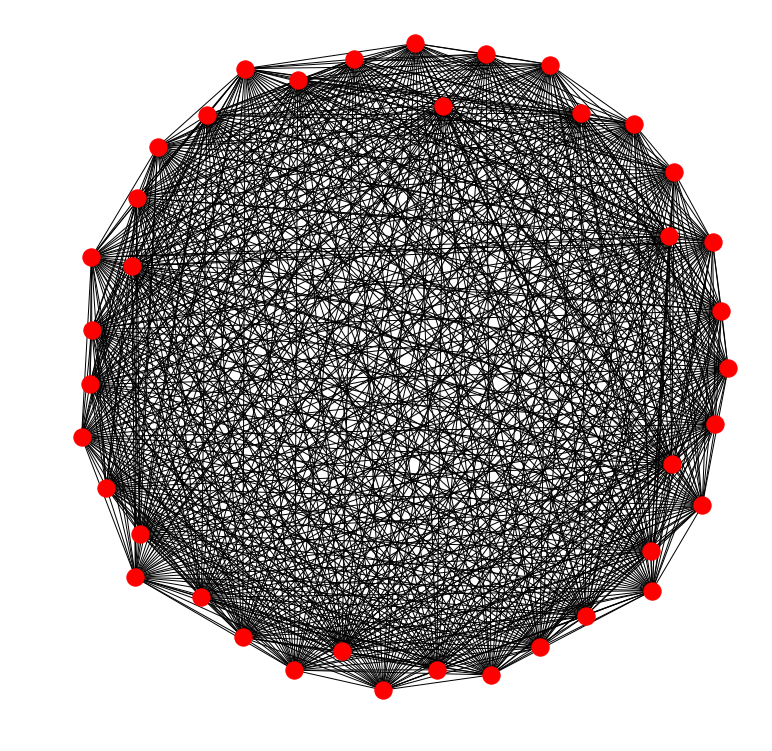

In [68]:
G = nx.from_pandas_adjacency(dist_matrix)
G = nx.drawing.nx_agraph.to_agraph(G)
G.node_attr.update(color="red", style="filled")
G.edge_attr.update(color="blue", width="1")
f = plt.figure(figsize=(10,10))
nx.draw(G, prog='neato')

In [81]:
cmapOP = pd.read_csv('Obsidian_Pool/MAGs/OP_finalbins_cmap30.tsv','\t').set_index('COG')

In [82]:
cmapOP.head()

,Obs2_genome_009,Obs4_genome_073,Obs3_genome_048,Obs5_genome_092,Obs3_genome_052,Obs6_genome_106,Obs4_genome_057,Obs4_genome_063,Obs5_genome_080,Obs4_genome_072,...,Obs2_genome_031,Obs6_genome_105,Obs2_genome_032,Obs3_genome_049,Obs3_genome_041,Obs2_genome_004,Obs2_genome_005,Obs4_genome_074,Obs2_genome_014,Obs6_genome_097
COG,,,,,,,,,,,,,,,,,,,,,
COG0001,1.0,1.0,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,...,1.0,NaN,NaN,NaN,1.0,NaN,1.0,1.0,1.0,1.0
COG0002,1.0,1.0,NaN,NaN,NaN,NaN,1.0,NaN,1.0,1.0,...,NaN,NaN,NaN,NaN,1.0,1.0,NaN,1.0,NaN,NaN
COG0003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN
COG0004,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN
COG0005,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,1.0


/home/bojk/miniconda3/envs/py360/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


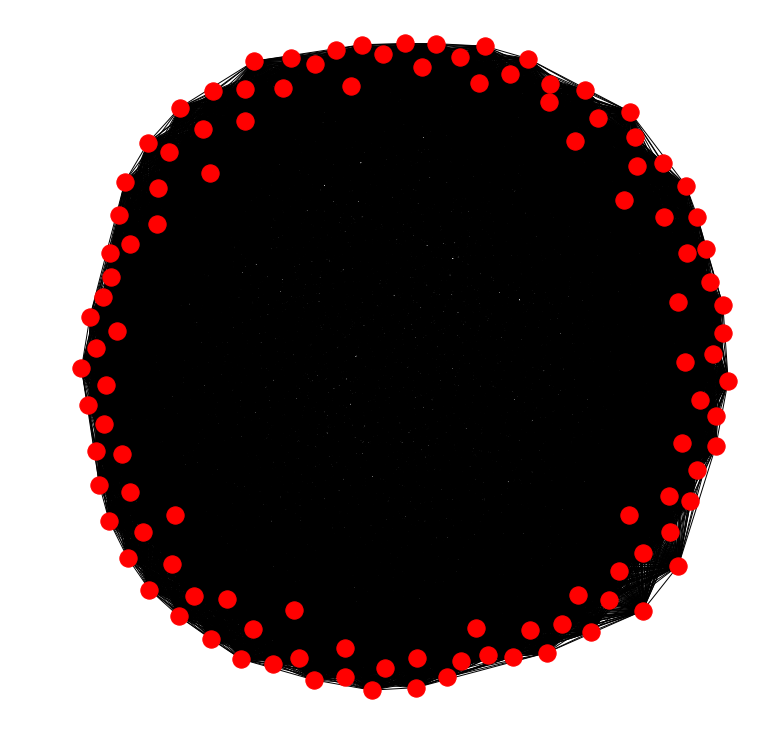

In [83]:
count_table = cmapOP.fillna(0).T
dist_matrix = pd.DataFrame(distance_matrix(count_table.values,count_table.values),index=count_table.index,columns=count_table.index)
G = nx.from_pandas_adjacency(dist_matrix)
G = nx.drawing.nx_agraph.to_agraph(G)
G.node_attr.update(color="red", style="filled")
G.edge_attr.update(color="blue", width=".01")
f = plt.figure(figsize=(10,10))
nx.draw(G, prog='neato')

,Obs2_genome_009,Obs4_genome_073,Obs3_genome_048,Obs5_genome_092,Obs3_genome_052,Obs6_genome_106,Obs4_genome_057,Obs4_genome_063,Obs5_genome_080,Obs4_genome_072,...,Obs2_genome_031,Obs6_genome_105,Obs2_genome_032,Obs3_genome_049,Obs3_genome_041,Obs2_genome_004,Obs2_genome_005,Obs4_genome_074,Obs2_genome_014,Obs6_genome_097
COG,,,,,,,,,,,,,,,,,,,,,
COG0001,1.0,1.0,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,...,1.0,NaN,NaN,NaN,1.0,NaN,1.0,1.0,1.0,1.0
COG0002,1.0,1.0,NaN,NaN,NaN,NaN,1.0,NaN,1.0,1.0,...,NaN,NaN,NaN,NaN,1.0,1.0,NaN,1.0,NaN,NaN
COG0003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN
COG0004,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN
COG0005,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,1.0
COG0006,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,...,NaN,1.0,NaN,NaN,1.0,1.0,1.0,1.0,NaN,1.0
COG0007,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,1.0
COG0008,1.0,1.0,NaN,1.0,1.0,NaN,1.0,1.0,1.0,NaN,...,NaN,1.0,1.0,NaN,1.0,1.0,NaN,NaN,NaN,1.0
COG0009,1.0,1.0,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,1.0,1.0,1.0,NaN,1.0,NaN
